# Прогнозирование оттока клиентов банка

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Имеются исторические данные о поведении клиентов и расторжении договоров с банком:

    - RowNumber — индекс строки в данных
    - CustomerId — уникальный идентификатор клиента
    - Surname — фамилия
    - CreditScore — кредитный рейтинг
    - Geography — страна проживания
    - Gender — пол
    - Age — возраст
    - Tenure — количество недвижимости у клиента
    - Balance — баланс на счёте
    - NumOfProducts — количество продуктов банка, используемых клиентом
    - HasCrCard — наличие кредитной карты
    - IsActiveMember — активность клиента
    - EstimatedSalary — предполагаемая зарплата
    - Exited — факт ухода клиента

***Цель:*** построить модель с предельно большим значением *F1*-меры (от 0.59). 

***Дополнительно:*** измерить *AUC-ROC*, сравнить её значение с *F1*-мерой.

### Содержание

1. [Подготовка данных](#preprocessing)
2. [Исправление дисбаланса классов](#models)
3. [Выбор и улучшение модели](#bestmodel)
4. [Выводы](#conclusion)

# Подготовка данных <a id = 'preprocessing'></id>

Импортируем библиотеки, необходимые модули и метрики:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings("ignore")

Прочитаем файл с историческими данными, сохраним его в переменную `data` и посмотрим на первые строки:

In [2]:
data = pd.read_csv('churn.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Избавимся от ненужных признаков, которые не несут в себе информации, полезной для обучения модели:

In [3]:
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis = 1)
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Узнаем количество наблюдений в датасете и типы данных в разных столбцах:

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           9091 non-null   float64
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


У нас есть 10 000 наблюдений, но в столбце с количеством недвижимости почти 10% данных пропущено.

Случайные ли это пропуски? Сравним наблюдения, где есть пропуски, со всеми остальными. Есть ли заметные различия в этих срезах данных?

In [5]:
data[data.Tenure.isnull()].mean()

CreditScore          648.451045
Age                   38.647965
Tenure                      NaN
Balance            76117.341474
NumOfProducts          1.530253
HasCrCard              0.710671
IsActiveMember         0.510451
EstimatedSalary    99180.389373
Exited                 0.201320
dtype: float64

In [6]:
data[~data.Tenure.isnull()].mean()

CreditScore           650.736553
Age                    38.949181
Tenure                  4.997690
Balance             76522.740015
NumOfProducts           1.530195
HasCrCard               0.704983
IsActiveMember          0.515565
EstimatedSalary    100181.214924
Exited                  0.203938
dtype: float64

Там, где пропущены значения в столбце с недвижимостью, другие признаки распределены примерно так же, как в остальном датасете. Скорее всего, пропуски носят случайный характер. 

Можно ли заменить их средним или медианой? Посмотрим на распределение данных в столбце с пропусками (`Tenure`):

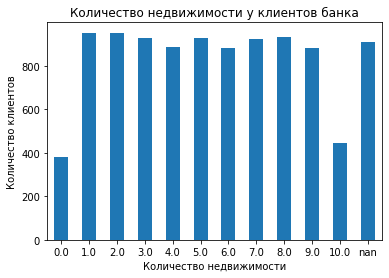

In [7]:
data.Tenure.value_counts(dropna = False).sort_index().plot(kind = 'bar', \
                                        title = 'Количество недвижимости у клиентов банка', rot = 0)
plt.xlabel('Количество недвижимости')
plt.ylabel('Количество клиентов');

Распределение количества объектов недвижимости выглядит не очень правдоподобно. Логика и здравый смысл подсказывают, что тех, кто владеет 5+ объектами недвижимости, должно быть меньше, чем тех, кто владеет 1-2.

Возможно, в описании данных ошибка и в этом столбце содержится не "количество недвижимости", а количество лет владения недвижимостью.

Посмотрим, коррелируют ли данные в этом столбце с предполагаемым доходом или балансом на счете:

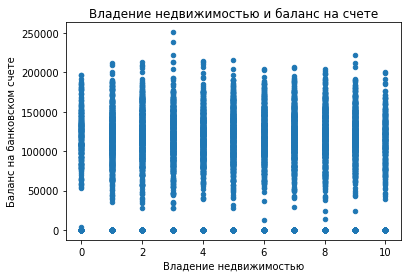

In [8]:
data.plot.scatter(x = 'Tenure', y = 'Balance')
plt.title('Владение недвижимостью и баланс на счете')
plt.xlabel('Владение недвижимостью')
plt.ylabel('Баланс на банковском счете');

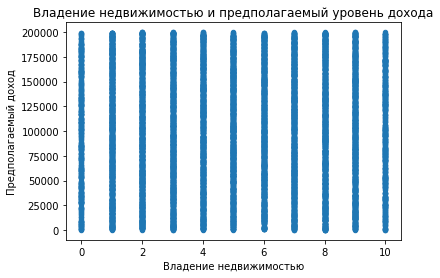

In [9]:
data.plot.scatter(x = 'Tenure', y = 'EstimatedSalary')
plt.title('Владение недвижимостью и предполагаемый уровень дохода')
plt.xlabel('Владение недвижимостью')
plt.ylabel('Предполагаемый доход');

Никакой заметной взаимосвязи не прослеживается. Скорее всего, если заменим пропуски средним/медианным значением, это ни на что не повлияет. 

Но если заменить пропуски средним или медианой, распределение данных в этом столбце заметно изменится: появится сильный перевес в пользу значения 5. 

Поэтому лучше заменим пропуски случайными значениями в диапазоне от 1 до 9, которые в нашей выборке встречаются примерно с одинаковой частотой:

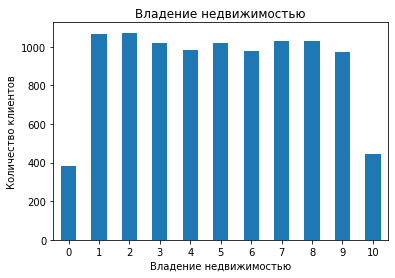

In [10]:
np.random.seed(5)
data.loc[data.Tenure.isna(), 'Tenure'] = np.random.randint(1, 10, 909)
data.Tenure = data.Tenure.astype('int')
data.Tenure.value_counts(dropna = False).sort_index().plot(kind = 'bar', \
                                        title = 'Владение недвижимостью', rot = 0)
plt.xlabel('Владение недвижимостью')
plt.ylabel('Количество клиентов');

Теперь все в порядке: пропусков больше нет, и при этом исходное распределение данных в столбце не изменилось.

В двух столбцах нашего датасета (`Geography` и `Gender`) содержатся данные типа object. Для обучения модели нужны данные в числовом виде.

Приведем данные в этих столбцах к числовым значениям, воспользовавшись техникой прямого кодирования (при этом удалим один из полученных столбцов, чтобы избежать "ловушки фиктивных признаков"):

In [11]:
data.Gender.value_counts(normalize = True)

Male      0.5457
Female    0.4543
Name: Gender, dtype: float64

In [12]:
data.Geography.value_counts(normalize = True)

France     0.5014
Germany    0.2509
Spain      0.2477
Name: Geography, dtype: float64

In [13]:
data = pd.get_dummies(data, drop_first=True)
data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


Проверим, что доли каждого класса не изменились:

In [14]:
data.Gender_Male.mean()

0.5457

In [15]:
data.Geography_Spain.mean()

0.2477

In [16]:
data.Geography_Germany.mean()

0.2509

Теперь подготовим данные к обучению модели: выделим признаки и целевой признак, разделим на обучающую, валидационную и тестовую выборки (в соотношении 3:1:1):

In [17]:
features = data.drop(['Exited'], axis = 1)
target = data['Exited']
print(features.shape)
features_train, features_t, target_train, target_t = train_test_split(features, target, test_size = 0.4, random_state = 12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_t, target_t, test_size = 0.5, random_state = 12345)
print(features_train.shape, features_valid.shape, features_test.shape)

(10000, 11)
(6000, 11) (2000, 11) (2000, 11)


Следующий шаг - масштабирование численных признаков. Используем метод стандартизации данных, чтобы алгоритм при обучении модели использовал все признаки как в равной степени значимые:

In [18]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(features_train.loc[:, numeric])
features_train.loc[:, numeric] = scaler.transform(features_train.loc[:, numeric])
features_valid.loc[:, numeric] = scaler.transform(features_valid.loc[:, numeric])
features_test.loc[:, numeric] = scaler.transform(features_test.loc[:, numeric])

# Исправление дисбаланса классов <a id = 'models'></id>

Посмотрим, какой баланс классов в нашем исходном датасете:

In [19]:
data.Exited.value_counts(normalize = True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

В нашей выборке клиентов, которые ушли из "Бета-Банка", в 4 раза меньше, чем тех, кто еще является клиентом. Значит, наблюдается довольно выраженный дисбаланс классов целевого признака.

Попробуем обучить модели без учета дисбаланса классов, а потом - с учетом этого дисбаланса. И сравним результаты (F1 score).

### Логистическая регрессия без учета дисбаланса классов

In [20]:
logreg = LogisticRegression(random_state = 12345, solver = 'liblinear')
logreg.fit(features_train, target_train)
predicted_valid = logreg.predict(features_valid)
f1_score(target_valid, predicted_valid)

0.33108108108108103

### Случайный лес без учета дисбаланса классов

In [21]:
ranfor = RandomForestClassifier(random_state = 12345, n_estimators = 100, max_depth = 10)
ranfor.fit(features_train, target_train)
predicted_valid = ranfor.predict(features_valid)
f1_score(target_valid, predicted_valid)

0.562111801242236

Теперь попробуем обучить такие же модели после использования **техники взвешивания классов**:

### Логистическая регрессия с учетом дисбаланса классов (взвешивание классов)

In [22]:
logreg = LogisticRegression(random_state = 12345, solver = 'liblinear', class_weight = 'balanced')
logreg.fit(features_train, target_train)
predicted_valid = logreg.predict(features_valid)
f1_score(target_valid, predicted_valid)

0.4893071000855432

### Случайный лес с учетом дисбаланса классов (взвешивание классов)

In [23]:
ranfor = RandomForestClassifier(random_state=12345, n_estimators = 100, max_depth = 10, \
                                class_weight = 'balanced')
ranfor.fit(features_train, target_train)
predicted_valid = ranfor.predict(features_valid)
f1_score(target_valid, predicted_valid)

0.6127864897466828

Попробуем другую технику (***upsampling***). Напишем и применим функцию для увеличения выборки, с учетом того, что в нашем датасете нынешних клиентов в 4 раза больше, чем бывших клиентов:

In [24]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
 
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, \
                                                   random_state=12345)
    
    return features_upsampled, target_upsampled

In [25]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

### Логистическая регрессия с учетом дисбаланса классов (upsampling)

In [26]:
#обучим модель логистической регрессии после исправления дисбаланса с помощью upsampling
logreg2 = LogisticRegression(random_state = 12345, solver = 'liblinear')
logreg2.fit(features_upsampled, target_upsampled)
predicted_valid2 = logreg2.predict(features_valid)
f1_score(target_valid, predicted_valid2)

0.48843187660668386

### Случайный лес с учетом дисбаланса классов (upsampling)

In [27]:
#обучим модель случайного леса после исправления дисбаланса с помощью upsampling
ranfor2 = RandomForestClassifier(random_state=12345, n_estimators = 100, max_depth = 10)
ranfor2.fit(features_upsampled, target_upsampled)
predicted_valid2 = ranfor2.predict(features_valid)
f1_score(target_valid, predicted_valid2)

0.6202393906420022

Попробуем другую технику (***downsampling***). Напишем и применим функцию для уменьшения выборки, с учетом того, что в нашем датасете нынешних клиентов в 4 раза больше, чем бывших клиентов:

In [28]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
 
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)]\
                                     + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)]\
                                   + [target_ones])
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, \
                                                       random_state=12345)
    return features_downsampled, target_downsampled

In [29]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

### Логистическая регрессия с учетом дисбаланса классов (downsampling)

In [30]:
#обучим модель логистической регрессии после исправления дисбаланса с помощью downsampling
logreg3 = LogisticRegression(random_state = 12345, solver = 'liblinear')
logreg3.fit(features_downsampled, target_downsampled)
predicted_valid3 = logreg3.predict(features_valid)
f1_score(target_valid, predicted_valid3)

0.4901117798796217

### Случайный лес с учетом дисбаланса классов (downsampling)

In [31]:
#обучим модель случайного леса после исправления дисбаланса с помощью downsampling
ranfor3 = RandomForestClassifier(random_state=12345, n_estimators = 100, max_depth = 10)
ranfor3.fit(features_downsampled, target_downsampled)
predicted_valid3 = ranfor3.predict(features_valid)
f1_score(target_valid, predicted_valid3)

0.5988593155893536

- Показатель F1 значительно повысился после исправления дисбаланса классов.

- Случайный лес показывает результаты заметно лучше, чем логистическая регрессия. Дальше будем работать с моделями случайного леса. 

- Попробуем улучшить их с использованием гиперпараметров и выясним, какая техника исправления дисбаланса классов дает наилучший результат.

# Выбор и улучшение модели <a id = 'bestmodel'></id>

Подберем оптимальные значения количества деревьев и глубины дерева с использованием разных техник исправления дисбаланса классов. 

Будем оптимизировать модели по двум метрикам: F1 score и ROC AUC. 

После обучения моделей сравним результаты и выберем лучшую.

### Взвешивание классов

- оптимизация по ***F1 score***:

In [32]:
best_model_cw_f1 = None
best_result_cw_f1 = 0
best_est = 0
best_depth = 0
for est in range(10, 121, 5):
    for depth in range(3, 15):
        model = RandomForestClassifier(random_state = 12345, n_estimators = est, max_depth = depth, \
                                      class_weight = 'balanced')
        model.fit(features_train, target_train)
        pred_valid = model.predict(features_valid)
        result = f1_score(target_valid, pred_valid)
        if result > best_result_cw_f1:
            best_model_cw_f1 = model
            best_result_cw_f1 = result
            best_est = est
            best_depth = depth

proba_one_valid_cw_f1 = best_model_cw_f1.predict_proba(features_valid)[:,1]
print('Оптимальное количество деревьев:', best_est)
print('Оптимальная глубина дерева:', best_depth)

Оптимальное количество деревьев: 65
Оптимальная глубина дерева: 7


- оптимизация по ***ROC AUC score***:

In [33]:
best_model_cw_rocauc = None
best_result_cw_rocauc = 0
best_est = 0
best_depth = 0
for est in range(10, 121, 5):
    for depth in range(3, 15):
        model = RandomForestClassifier(random_state = 12345, n_estimators = est, max_depth = depth, \
                                      class_weight = 'balanced')
        model.fit(features_train, target_train)
        proba_one_valid = model.predict_proba(features_valid)[:,1]
        result = roc_auc_score(target_valid, proba_one_valid)
        if result > best_result_cw_rocauc:
            best_model_cw_rocauc = model
            best_result_cw_rocauc = result
            best_est = est
            best_depth = depth

pred_valid_cw_rocauc = best_model_cw_rocauc.predict(features_valid)
proba_one_valid_cw_rocauc = best_model_cw_rocauc.predict_proba(features_valid)[:,1]
print('Оптимальное количество деревьев:', best_est)
print('Оптимальная глубина дерева:', best_depth)

Оптимальное количество деревьев: 115
Оптимальная глубина дерева: 7


### Техника upsampling

- оптимизация по ***F1 score***:

In [34]:
best_model_up_f1 = None
best_result_up_f1 = 0
best_est = 0
best_depth = 0
for est in range(10, 121, 5):
    for depth in range(3, 15):
        model = RandomForestClassifier(random_state = 12345, n_estimators = est, max_depth = depth)
        model.fit(features_upsampled, target_upsampled)
        pred_valid = model.predict(features_valid)
        result = f1_score(target_valid, pred_valid)
        if result > best_result_up_f1:
            best_model_up_f1 = model
            best_result_up_f1 = result
            best_est = est
            best_depth = depth
            
proba_one_valid_up_f1 = best_model_up_f1.predict_proba(features_valid)[:,1]
print('Оптимальное количество деревьев:', best_est)
print('Оптимальная глубина дерева:', best_depth)

Оптимальное количество деревьев: 25
Оптимальная глубина дерева: 14


- оптимизация по ***ROC AUC score***:

In [35]:
best_model_up_rocauc = None
best_result_up_rocauc = 0
best_est = 0
best_depth = 0
for est in range(10, 121, 5):
    for depth in range(3, 15):
        model = RandomForestClassifier(random_state = 12345, n_estimators = est, max_depth = depth)
        model.fit(features_upsampled, target_upsampled)
        proba_one_valid = model.predict_proba(features_valid)[:,1]
        result = roc_auc_score(target_valid, proba_one_valid)
        if result > best_result_up_rocauc:
            best_model_up_rocauc = model
            best_result_up_rocauc = result
            best_est = est
            best_depth = depth

pred_valid_up_rocauc = best_model_up_rocauc.predict(features_valid)
proba_one_valid_up_rocauc = best_model_up_rocauc.predict_proba(features_valid)[:,1]

print('Оптимальное количество деревьев:', best_est)
print('Оптимальная глубина дерева:', best_depth)

Оптимальное количество деревьев: 115
Оптимальная глубина дерева: 8


### Техника downsampling

- оптимизация по ***F1 score***:

In [36]:
best_model_down_f1 = None
best_result_down_f1 = 0
best_est = 0
best_depth = 0
for est in range(10, 121, 5):
    for depth in range(3, 15):
        model = RandomForestClassifier(random_state = 12345, n_estimators = est, max_depth = depth)
        model.fit(features_downsampled, target_downsampled)
        pred_valid = model.predict(features_valid)
        result = f1_score(target_valid, pred_valid)
        if result > best_result_down_f1:
            best_model_down_f1 = model
            best_result_down_f1 = result
            best_est = est
            best_depth = depth
            
proba_one_valid_down_f1 = best_model_down_f1.predict_proba(features_valid)[:,1]
print('Оптимальное количество деревьев:', best_est)
print('Оптимальная глубина дерева:', best_depth)

Оптимальное количество деревьев: 10
Оптимальная глубина дерева: 4


- оптимизация по ***ROC AUC score***:

In [37]:
best_model_down_rocauc = None
best_result_down_rocauc = 0
best_est = 0
best_depth = 0
for est in range(10, 121, 5):
    for depth in range(3, 15):
        model = RandomForestClassifier(random_state = 12345, n_estimators = est, max_depth = depth)
        model.fit(features_downsampled, target_downsampled)
        proba_one_valid = model.predict_proba(features_valid)[:,1]
        result = roc_auc_score(target_valid, proba_one_valid)
        if result > best_result_down_rocauc:
            best_model_down_rocauc = model
            best_result_down_rocauc = result
            best_est = est
            best_depth = depth
            
pred_valid_down_rocauc = best_model_down_rocauc.predict(features_valid)
proba_one_valid_down_rocauc = best_model_down_rocauc.predict_proba(features_valid)[:,1]

print('Оптимальное количество деревьев:', best_est)
print('Оптимальная глубина дерева:', best_depth)

Оптимальное количество деревьев: 85
Оптимальная глубина дерева: 6


### Сравнение результатов моделей на валидационной выборке

In [38]:
print('Взвешивание классов, оптимизация по F1 score:')
print('F1 score:', round(best_result_cw_f1, 4))
print('ROC-AUC score:', round(roc_auc_score(target_valid, proba_one_valid_cw_f1), 4))
print()
print('Взвешивание классов, оптимизация по ROC AUC:')
print('F1 score:', round(f1_score(target_valid, pred_valid_cw_rocauc), 4))
print('ROC-AUC score:', round(best_result_cw_rocauc, 4))
print()
print('Upsampling, оптимизация по F1 score:')
print('F1 score:', round(best_result_up_f1, 4))
print('ROC-AUC score:', round(roc_auc_score(target_valid, proba_one_valid_up_f1), 4))
print()
print('Upsampling, оптимизация по ROC AUC:')
print('F1 score:', round(f1_score(target_valid, pred_valid_up_rocauc), 4))
print('ROC-AUC score:', round(best_result_up_rocauc, 4))
print()
print('Downsampling, оптимизация по F1 score:')
print('F1 score:', round(best_result_down_f1, 4))
print('ROC-AUC score:', round(roc_auc_score(target_valid, proba_one_valid_down_f1), 4))
print()
print('Downsampling, оптимизация по ROC AUC:')
print('F1 score:', round(f1_score(target_valid, pred_valid_down_rocauc), 4))
print('ROC-AUC score:', round(best_result_down_rocauc, 4))

Взвешивание классов, оптимизация по F1 score:
F1 score: 0.6356
ROC-AUC score: 0.8545

Взвешивание классов, оптимизация по ROC AUC:
F1 score: 0.6263
ROC-AUC score: 0.8549

Upsampling, оптимизация по F1 score:
F1 score: 0.6241
ROC-AUC score: 0.8351

Upsampling, оптимизация по ROC AUC:
F1 score: 0.6143
ROC-AUC score: 0.8551

Downsampling, оптимизация по F1 score:
F1 score: 0.6081
ROC-AUC score: 0.8348

Downsampling, оптимизация по ROC AUC:
F1 score: 0.5917
ROC-AUC score: 0.8501


Наилучшие результаты продемонстрировала модель, в которой используется **взвешивание классов**. 

Оптимизация по F1 score кажется более удачной, поскольку модель демонстрирует заметно более высокий F1 score при том, что ROC AUC лишь немного уступает результату модели, которая оптимизировалась по ROC AUC.

Построим ***ROC-кривые*** для двух моделей:

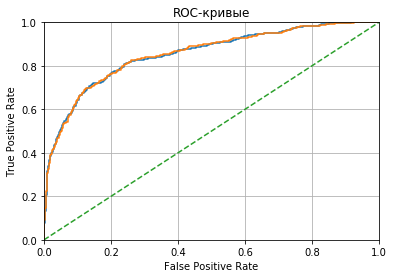

In [39]:
fpr_f1, tpr_f1, thresholds = roc_curve(target_valid, proba_one_valid_cw_f1)
fpr_roc, tpr_roc, thresholds = roc_curve(target_valid, proba_one_valid_cw_rocauc)
plt.figure()
plt.step(fpr_f1, tpr_f1)
plt.step(fpr_roc, tpr_roc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые')
plt.grid(True)
plt.show()

Как видим, ROC-кривые для двух моделей практически совпадают.

Проверим, какие F1 и ROC AUC на тестовой выборке.

Показатели модели, которую оптимизировали по ***F1 score***:

In [40]:
pred_test_cw_f1 = best_model_cw_f1.predict(features_test)
print('F1 score на тестовой выборке:', round(f1_score(target_test, pred_test_cw_f1), 4))

F1 score на тестовой выборке: 0.6109


In [41]:
prob_one_test_cw_f1 = best_model_cw_f1.predict_proba(features_test)[:,1]
print('ROC AUC на тестовой выборке', round(roc_auc_score(target_test, prob_one_test_cw_f1), 4))

ROC AUC на тестовой выборке 0.8528


Показатели модели, которую оптимизировали по ***ROC AUC***:

In [42]:
pred_test_cw_roc = best_model_cw_rocauc.predict(features_test)
print('F1 score на тестовой выборке:', round(f1_score(target_test, pred_test_cw_roc), 4))

F1 score на тестовой выборке: 0.609


In [43]:
prob_one_test_cw_roc = best_model_cw_rocauc.predict_proba(features_test)[:,1]
print('ROC AUC на тестовой выборке:', round(roc_auc_score(target_test, prob_one_test_cw_roc), 4))

ROC AUC на тестовой выборке: 0.8546


Показатели чуть ниже, чем на валидационной выборке, но разница не критична. Значит, модель не переобучена и справляется с задачей на новых данных.

Модель, которую оптимизировали по F1 score, показывает лучший F1 score и на тестовых данных. 

И наоборот: модель, которую оптимизировали по ROC AUC, на тестовой выборке также демонстрирует более высокий ROC AUC. 

В нашем случае основной параметр, на который ориентируемся, - F1 score. Поэтому остановимся на модели `best_model_cw_f1`.

# Выводы <a id = 'conclusion'></id>

На этапе предобработки:
    - избавились от бесполезных признаков и пропусков в данных;
    - привели категориальные признаки к числовому виду;
    - масштабировали числовые признаки;
    - выделили признаки для обучения модели и целевой признак;
    - разделили данные на обучающую, валидационную и тестовую выборки (3:1:1).
    
Обучили модели логистической регрессии и случайного леса: сначала без учета дисбаланса классов, затем после исправления дисбаланса классов при помощи разных техник. 

Выбрали алгоритм, который демонстрирует наилучшие результаты на валидационной выборке (**случайный лес**).

Подобрали **гиперпараметры (количество деревьев и максимальную глубину дерева)**, которые дают наилучший результат **по F1 score и по ROC AUC**.

Сравнили модели, использующие разные техники исправления дисбаланса классов (взвешивание классов, upsampling, downsampling). Наилучшие результаты продемонстрировали модели, использующие **взвешивание классов**. 

Получили **две лучшие модели с максимальной глубиной дерева 7 и с разным количеством деревьев (65 и 115)**. Построили для них ROC-кривые, сравнили показатели F1 и ROC AUC на валидационной выборке. 

Проверили работу моделей на тестовой выборке. Наилучший результат дает модель, которая оптимизировалась по **F1 score**.

Остановились на модели `best_model_cw_f1`, которая продемонстрировала наилучшие результаты:
    - F1 score: 0.6356 на валидационной выборке и 0.6109 на тестовой выборке;
    - ROC AUC: 0.8545 на валидационной выборке и 0.8528 на тестовой выборке.